# Estimating Eigenfunctions of the Transfer Operator

_Author_: [Pietro Novelli](https://pietronvll.github.io/)

This example is a reproduction of the second experiment of _"Sharp Spectral Rates for Koopman Operator Learning"_<cite data-footcite="Kostic2023SpectralRates">(Kostic et al. 2023)</cite>. We use `kooplearn` to approximate the leading eigenfunctions of the transfer operator of the overdamped Langevin dynamics
$$
X_{t + 1} = X_t -\frac{1}{\gamma}\nabla V(X_t)\Delta t + \frac{\sigma}{\gamma}\sqrt(\Delta t)\xi_t
$$
Here, $V$ is the potential function, $\gamma$ is a damping coefficient, and $\sigma$ is proportional to the temperature of the process: the higher the $\sigma$, the noisier is the dynamics. In this example we will study the so-called _Prinz Potential_<cite data-footcite="Prinz2011">(Prinz et al. 2011)</cite>:

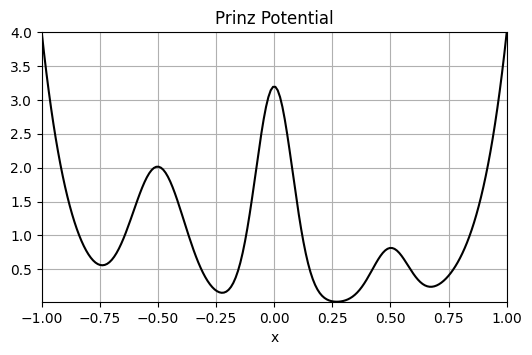

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [6., 3.5]

def prinz_potential(x):
    return 4 * (
        x**8
        + 0.8 * np.exp(-80 * (x**2))
        + 0.2 * np.exp(-80 * ((x - 0.5) ** 2))
        + 0.5 * np.exp(-40 * ((x + 0.5) ** 2))
    )

x = np.linspace(-1, 1, 200)
plt.plot(x, prinz_potential(x), 'k')
plt.margins(0)
plt.xlabel('x')
plt.title("Prinz Potential")
plt.grid()

`kooplearn` exposes the function [make_prinz_potential](../generated/kooplearn.datasets.make_prinz_potential.rst) to simulate the overdamped Langevin dynamics with this potential. 

In [2]:
from kooplearn.datasets import make_prinz_potential

gamma = 1.0
sigma = 2.0
data = make_prinz_potential(X0 = 0, n_steps=int(5e6), gamma=gamma, sigma=sigma)

for overdamped Langevin processes, the inverse temperature satisfies the relation $\beta = 2\gamma/\sigma^2$. With this, we can easily verify that `data` approximately samples the Boltzmann distribution $e^{-\beta V(x)}$.

Text(0.5, 0, 'x')

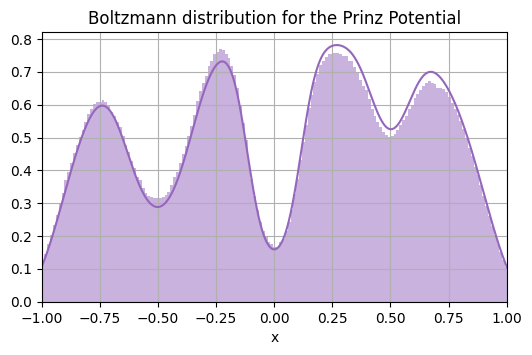

In [3]:
from scipy.integrate import romb


def compute_boltzmann_density(x, gamma, sigma):
    beta = 2*gamma/(sigma**2)
    pdf = np.exp(-beta*prinz_potential(x))
    total_mass = romb(pdf, dx=x[1] - x[0])
    return pdf/total_mass

x = np.linspace(-2, 2, 2048 + 1)
density = compute_boltzmann_density(x, gamma ,sigma)
plt.hist(data, bins=200, density=True, alpha=0.5, color="tab:purple")
plt.plot(x, density, color='tab:purple')
plt.xlim(-1, 1)
plt.grid()
plt.title("Boltzmann distribution for the Prinz Potential")
plt.xlabel("x")

### Estimating the eigenfunctions
We will compare the _Reduced Rank Regression_ estimator <cite data-footcite="Kostic2022">(Kostic et al. 2022)</cite> against the classical _Principal Component_ estimator, also known as kernel DMD <cite data-footcite="Williams2015_KDMD">(Williams et al. 2015)</cite>. To this end, we use `kooplearn`'s [KernelRidge](../generated/kooplearn.kernel.KernelRidge.rst) class, with a simple Gaussian kernel (`rbf`).

In [4]:
from kooplearn.kernel import KernelRidge


def fit_and_estimate(reduced_rank, x, density):
    subsample = 100  # We need long trajectories to sample the Boltzmann distribution...
    gamma = 1.0
    sigma = 2.0
    data = make_prinz_potential(X0=0, n_steps=int(5e5), gamma=gamma, sigma=sigma)
    data = data.iloc[::subsample]  # ...but we don't need all the data to estimate the eigenfunctions
    model = KernelRidge(
        n_components=5, reduced_rank=reduced_rank, gamma=12.5, kernel="rbf", alpha=1e-6
    )  # Model definition
    model.fit(data)
    values, functions = model.eig(eval_right_on=x)  # Eigenvalue estimation
    sort_perm = np.flip(np.argsort(np.abs(values))) # Order eigenvalues decreasingly
    values, functions = values[sort_perm], functions[:, sort_perm]
    functions = normalize_eigenfunctions(functions, x, density)
    return functions


def normalize_eigenfunctions(functions, x, density):
    abs2_eigfun = (np.abs(functions) ** 2).T  # f(x)**2
    abs2_eigfun *= density  # Compute the norm with respect to the Boltzmann measure.
    dx = x[1] - x[0]
    funcs_norm = np.sqrt(romb(abs2_eigfun, dx=dx, axis=1))  # Norms
    functions *= funcs_norm**-1.0  # Normalize
    return functions

The code above is straightforward: the function `fit_and_estimate` samples a fresh new trajectory, fits a transfer operator model, computes its (right) eigenfunctions via `model.eig`, and evaluates it on the array `x` via the argument `eval_right_on=x`. Finally, it computes the normalization constant
$$\left(\int e^{-\beta V(x)} |\psi(x)|^2dx\right)^{1/2} $$
via the `normalize_eigenfunctions` helper method. We now run this function for both Reduced Rank (`reduced_rank = True`) and Principal Component (`reduced_rank = False`) estimators. To gather some statistics, we repeat the evaluation multiple times. 

In [5]:
from collections import defaultdict

from tqdm import tqdm

dt = 1e-4
n_repetitions = 10
results = defaultdict(list)
for method, reduced_rank in zip(["Principal Components (kDMD)", "Reduced Rank"], [False, True]):
    for _ in tqdm(range(n_repetitions)):
        results[method].append(fit_and_estimate(reduced_rank, x[:, None], density))

100%|██████████| 10/10 [01:07<00:00,  6.77s/it]


let's print some results

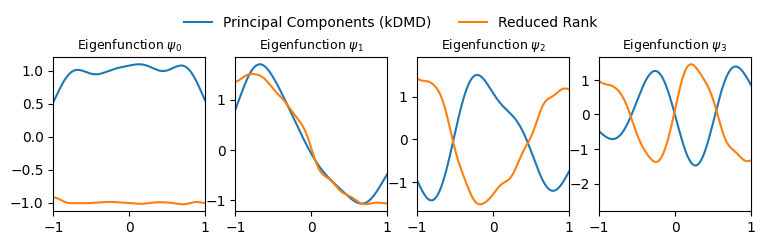

In [6]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        color = "tab:blue" if "Principal" in method else "tab:orange"
        ax.plot(x, functions[0][:, fun_id], color=color, label=method)
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=2,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

As we can see, some eigenfunctions seem to have a sign mismatch. This is to be expected, as the spectral decomposition is [not unique](https://math.stackexchange.com/questions/1702730/sign-of-normalized-eigenvector-for-singular-value-decomposition), and multiplying by a constant scalar value (including -1), returns a valid eigenvector. To overcome this issue, we can write down a simple helper function to standardize them

In [7]:
def standardize_sign(eigenfunction, reference, x):
    eigenfunction_cut = cut_functions_to_domain(eigenfunction, x)
    reference_cut = cut_functions_to_domain(reference, x)
    norm_p = np.linalg.norm(eigenfunction_cut + reference_cut)
    norm_m = np.linalg.norm(eigenfunction_cut - reference_cut)
    if norm_p <= norm_m:
        return -1.0*eigenfunction
    else:
        return eigenfunction

def cut_functions_to_domain(functions, x, x_lims=(-1, 1)):
    mask = (x >= x_lims[0]) & (x <= x_lims[1])
    return functions[mask]

def compute_ylims(reference, margin=0.1):
    ref_min = reference.min()
    ref_max = reference.max()
    if ref_min < 0:
        ref_min *= (1 + margin)
    else:
        ref_min *= (1 - margin)
    if ref_max < 0:
        ref_max *= (1 - margin)
    else:
        ref_max *= (1 + margin)

    y_min = np.round(ref_min, 1)
    y_max = np.round(ref_max, 1)
    return y_min, y_max

`kooplearn` also exposes the function [compute_prinz_potential_eig](../generated/kooplearn.datasets.compute_prinz_potential_eig.rst) returning the exact eigenfunctions associated to the Prinz Potential dynamics. We will now use it to get the reference eigenfunctions, so that we can compare our estimators:

In [8]:
from kooplearn.datasets import compute_prinz_potential_eig

dt = data.attrs["params"]["dt"]
_, reference_eigfuns = compute_prinz_potential_eig(
    gamma, sigma, dt, eval_right_on=x, num_components=5
)
reference_eigfuns = normalize_eigenfunctions(reference_eigfuns, x, density)

we can finally plot everything together

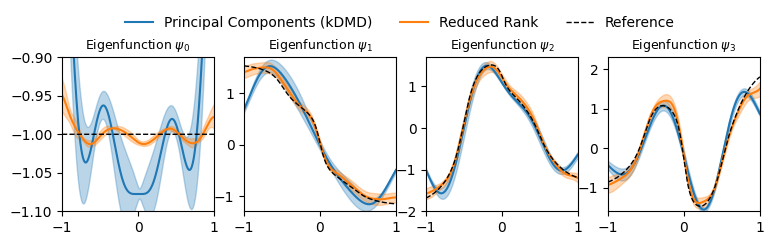

In [9]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    reference = reference_eigfuns[:, fun_id]
    for method, functions in results.items():
        if method in ["Principal Components (kDMD)", "Reduced Rank"]:
            # Standardize signs according to the reference
            functions = np.array(functions) # Convert list of arrays into array
            for i in range(n_repetitions):
                for j in range(functions.shape[-1]):
                    functions[i, :, j] = standardize_sign(
                        functions[i, :, j], reference_eigfuns[:, j], x
                    )
            color = 'tab:blue' if 'Principal' in method else 'tab:orange'
            m = functions.mean(0)[:, fun_id]
            st = functions.std(0)[:, fun_id]
            ax.plot(x, m, color=color, label=method)
            ax.fill_between(x, m - st, m + st, color=color, alpha=0.3)
            ax.set_ylim(compute_ylims(reference))
    ax.plot(x, reference, color='k', lw=1, ls='--', label='Reference')
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=3,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

...showing that the _Reduced Rank_ estimator approximates the reference eigenfunctions much better than the more common _Principal Component Regression_ (kernel DMD).

## A Representation Learning Approach
In this section, we move beyond prescribed feature maps and kernel methods. Here, we adopt a **representation learning** strategy. We aim to learn a mapping $\varphi$ that transforms the system's state into a latent space where the evolution of dynamics is linear, effectively approximating the eigenfunctions.


### Spectral Contrastive Loss
To achieve this, we train an encoder-only model optimized via the [SpectralContrastiveLoss](../generated/kooplearn.torch.nn.SpectralContrastiveLoss.rst).

The model architecture is twofold:
* **Encoder:** A Multilayer Perceptron (MLP) that lifts the state to the latent space.
* **Predictor:** A linear layer that evolves the state forward in time.

See *"Self-Supervised Evolution Operator Learning for High-Dimensional Dynamical Systems"* <cite data-footcite="turri2025self">(Turri et al. 2025)</cite> for the theoretical background.


In [10]:
import torch

n_train_samples = 10000
n_val_samples = 1000

subsample = 100
data = make_prinz_potential(X0=0, n_steps=int(2e6), gamma=gamma, sigma=sigma)
data = data.iloc[::subsample]  # ...but we don't need all the data to estimate the eigenfunctions

train_data = torch.from_numpy(data[:n_train_samples].values).float()
val_data = torch.from_numpy(data[-n_val_samples:].values).float()

In [11]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512

# Creating PyTorch TensorDatasets
train_ds = TensorDataset(train_data[:-1], train_data[1:])
val_ds = TensorDataset(val_data[:-1], val_data[1:])

# Creating DataLoaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

In [12]:
# Experiment hyperparameters
learning_rate = 1e-3
opt = torch.optim.AdamW
num_epochs = 200
layer_dims = [32, 64, 32]
latent_dim = 32
random_state = 42

In [13]:
class SimpleMLP(torch.nn.Module):
    def __init__(
        self, latent_dim: int, layer_dims: list[int], activation=torch.nn.SiLU
    ):
        super().__init__()
        self.activation = activation
        lin_dims = ([1] + layer_dims + [latent_dim])

        layers = []

        for layer_idx in range(len(lin_dims)-2):
            layers.append(
                torch.nn.Linear(
                    lin_dims[layer_idx], lin_dims[layer_idx + 1], bias=False
                )
            )
            layers.append(activation())

        layers.append(torch.nn.Linear(lin_dims[-2], lin_dims[-1], bias=True))

        self.layers = torch.nn.ModuleList(layers)

    def forward(self, x):
        # MLP
        for layer in self.layers:
            x = layer(x)
        return x

In [14]:
from kooplearn.linear_model import Ridge
from kooplearn.torch.utils import FeatureMapEmbedder

device = "cuda" if torch.cuda.is_available() else "cpu"

class FeatureMap(torch.nn.Module):
    def __init__(self, latent_dim: int, normalize_latents: bool = False):
        super().__init__()
        self.normalize_latents = normalize_latents
        self.backbone = SimpleMLP(latent_dim=latent_dim, layer_dims=layer_dims)
        self.lin = torch.nn.Linear(latent_dim, latent_dim, bias=False)

    def forward(self, X, lagged: bool = False):
        z = self.backbone(X)
        if self.normalize_latents:
            z = torch.nn.functional.normalize(z, dim=-1)
        if lagged:
            z = self.lin(z)
        return z


def train_encoder_only(criterion: torch.nn.Module):
    torch.manual_seed(random_state)
    # Initialize model, loss and optimizer
    model = FeatureMap(latent_dim).to(device)
    optimizer = opt(model.parameters(), lr=learning_rate)

    def step(batch, is_train: bool = True):
        batch_X, batch_Y = batch
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        if is_train:
            optimizer.zero_grad()
        phi_X, phi_Y = model(batch_X), model(batch_Y, lagged=True)
        loss = criterion(phi_X, phi_Y)
        if is_train:
            loss.backward()
            optimizer.step()
        return loss.item()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = []
        for batch in train_dl:
            train_loss.append(step(batch))
        # Validation phase
        model.eval()
        val_loss = []
        with torch.no_grad():
            for batch in val_dl:
                val_loss.append(step(batch, is_train=False))

        if (epoch + 1) % 10 == 0 or (epoch == 0):
            print(
                f"EPOCH {epoch + 1:>2}  Loss: {np.mean(train_loss):.2f} (train) -  {np.mean(val_loss):.2f} (val)"
            )

    embedder = FeatureMapEmbedder(encoder=model, device=device)
    evolution_operator_model = Ridge(n_components=latent_dim).fit(
        embedder.transform(train_data), train_data.numpy(force=True)
    )

    return {
        "model": evolution_operator_model,
        "feature_map": embedder.transform,
    }

In [15]:
from kooplearn.torch.nn import SpectralContrastiveLoss

trained_models = {}
trained_models["Spectral Contrastive Loss"] = train_encoder_only(SpectralContrastiveLoss())

EPOCH  1  Loss: -0.23 (train) -  -0.64 (val)
EPOCH 10  Loss: -1.90 (train) -  -1.57 (val)
EPOCH 20  Loss: -2.46 (train) -  -2.04 (val)
EPOCH 30  Loss: -2.50 (train) -  -2.06 (val)
EPOCH 40  Loss: -2.51 (train) -  -2.05 (val)
EPOCH 50  Loss: -2.53 (train) -  -2.13 (val)
EPOCH 60  Loss: -2.85 (train) -  -2.45 (val)
EPOCH 70  Loss: -2.98 (train) -  -2.50 (val)
EPOCH 80  Loss: -3.00 (train) -  -2.55 (val)
EPOCH 90  Loss: -3.01 (train) -  -2.61 (val)
EPOCH 100  Loss: -3.02 (train) -  -2.55 (val)
EPOCH 110  Loss: -3.02 (train) -  -2.46 (val)
EPOCH 120  Loss: -3.08 (train) -  -2.57 (val)
EPOCH 130  Loss: -3.09 (train) -  -2.59 (val)
EPOCH 140  Loss: -3.11 (train) -  -2.59 (val)
EPOCH 150  Loss: -3.11 (train) -  -2.62 (val)
EPOCH 160  Loss: -3.15 (train) -  -2.73 (val)
EPOCH 170  Loss: -3.19 (train) -  -2.73 (val)
EPOCH 180  Loss: -3.18 (train) -  -2.68 (val)
EPOCH 190  Loss: -3.19 (train) -  -2.68 (val)


The rank attribute has been updated to 20.
Consider decreasing the rank parameter.


EPOCH 200  Loss: -3.18 (train) -  -2.66 (val)


In [16]:
def estimate_representations(model, embedder, x, density):
    values, functions = model.eig(eval_right_on=embedder(x))  # Eigenvalue estimation
    sort_perm = np.flip(np.argsort(np.abs(values))) # Order eigenvalues decreasingly
    values, functions = values[sort_perm], functions[:, sort_perm]
    functions = normalize_eigenfunctions(functions, x, density)
    return functions

In [17]:
for model_id, trained_model in trained_models.items():
    results[model_id] = [estimate_representations(trained_model["model"], trained_model["feature_map"], x[:, None], density)]

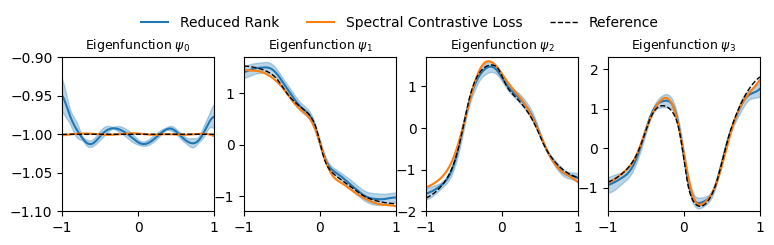

In [18]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        if method in ["Reduced Rank", "Spectral Contrastive Loss"]:
            # Standardize signs according to the reference
            functions = np.array(functions) # Convert list of arrays into array
            n_reps = functions.shape[0]
            for i in range(n_reps):
                for j in range(reference_eigfuns.shape[-1]):
                    functions[i, :, j] = standardize_sign(
                        functions[i, :, j], reference_eigfuns[:, j], x
                    )
            color = 'tab:blue' if 'Reduced Rank' in method else 'tab:orange'
            m = functions.mean(0)[:, fun_id].real
            st = functions.std(0)[:, fun_id].real
            ax.plot(x, m, color=color, label=method)
            ax.fill_between(x, m - st, m + st, color=color, alpha=0.3)
    reference = reference_eigfuns[:, fun_id]
    ax.plot(x, reference, color='k', lw=1, ls='--', label='Reference')
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
    ax.set_ylim(compute_ylims(reference))
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=3,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)

Notably, optimizing the mapping $\varphi$ with the [SpectralContrastiveLoss](../generated/kooplearn.torch.nn.SpectralContrastiveLoss.rst) enables a precise estimation of eigenfunctions—including the trivial constant function $\Psi_0$, which remains flat unlike in standard Reduced Rank models.

### Generator learning
We further train another model using the [EnergyLoss](../generated/kooplearn.torch.nn.EnergyLoss.rst). [TODO]

In [19]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512

# Creating PyTorch TensorDatasets
train_ds = TensorDataset(train_data[:-1])
val_ds = TensorDataset(val_data[:-1])

# Creating DataLoaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

In [20]:
class GeneratorFeatureMap(torch.nn.Module):
    def fmap_grad(self, x, u):
        """
        Compute gradient of a DNN embedding u w.r.t. batch x, i.e U = u(x).
        Parameters
        ----------
        x : torch.Tensor, shape (b, d)
            Input data with requires_grad=True.
        u : DNN embedding function that maps x to array of shape (b, l)
        Returns
        -------
        Ugrad : torch.Tensor, shape (b, d, l)
            Jacobian of U wrt x.
        """
        x = x.clone().detach().requires_grad_(True)
        U = u(x)  # (b, l)
        U_dim = U.shape[1]
        # First derivatives (Jacobian)
        Ugrad = []
        for i in range(U_dim):
            grad_i = torch.autograd.grad(
                U[:, i].sum(),
                x,
                retain_graph=True
            )[0]  # (b, d)
            Ugrad.append(grad_i)
        Ugrad = torch.stack(Ugrad, dim=2)  # (b, d, l)
        return Ugrad

    def __init__(self, latent_dim: int, normalize_latents: bool = False):
        super().__init__()
        self.normalize_latents = normalize_latents
        self.backbone = SimpleMLP(latent_dim=latent_dim, layer_dims=layer_dims)

    def forward(self, X, grad: bool = False):
        z = self.backbone(X)
        if self.normalize_latents:
            z = torch.nn.functional.normalize(z, dim=-1)
        if grad:
            z = self.fmap_grad(X, self.backbone)
        return z


def train_encoder_only(criterion: torch.nn.Module):
    torch.manual_seed(random_state)
    # Initialize model, loss and optimizer
    model = GeneratorFeatureMap(latent_dim).to(device)
    optimizer = opt(model.parameters(), lr=learning_rate)

    def step(batch, is_train: bool = True):
        X = batch[0]
        X = X.to(device)
        if is_train:
            optimizer.zero_grad()
        phi_X, grad_phi_X = model(X), model(X, grad=True)
        loss = criterion(phi_X, grad_phi_X)
        if is_train:
            loss.backward()
            optimizer.step()
        return loss.item()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = []
        for batch in train_dl:
            train_loss.append(step(batch))
        # Validation phase
        model.eval()
        val_loss = []
        for batch in val_dl:
            val_loss.append(step(batch, is_train=False))

        if (epoch + 1) % 10 == 0 or (epoch == 0):
            print(
                f"EPOCH {epoch + 1:>2}  Loss: {np.mean(train_loss):.2f} (train) -  {np.mean(val_loss):.2f} (val)"
            )

    embedder = FeatureMapEmbedder(encoder=model, device=device)
    evolution_operator_model = Ridge(n_components=latent_dim).fit(
        embedder.transform(train_data), train_data.numpy(force=True)
    )

    return {
        "model": evolution_operator_model,
        "feature_map": embedder.transform,
    }

In [21]:
from kooplearn.torch.nn import EnergyLoss

trained_models["Energy Loss"] = train_encoder_only(EnergyLoss(grad_weight=1e-6))

EPOCH  1  Loss: -0.74 (train) -  -1.05 (val)
EPOCH 10  Loss: -2.34 (train) -  -2.16 (val)
EPOCH 20  Loss: -2.97 (train) -  -2.50 (val)
EPOCH 30  Loss: -2.97 (train) -  -2.56 (val)
EPOCH 40  Loss: -2.98 (train) -  -2.54 (val)
EPOCH 50  Loss: -3.38 (train) -  -2.94 (val)
EPOCH 60  Loss: -3.94 (train) -  -3.38 (val)
EPOCH 70  Loss: -3.94 (train) -  -3.37 (val)
EPOCH 80  Loss: -3.96 (train) -  -3.34 (val)
EPOCH 90  Loss: -3.95 (train) -  -3.36 (val)
EPOCH 100  Loss: -3.99 (train) -  -3.34 (val)
EPOCH 110  Loss: -4.49 (train) -  -3.98 (val)
EPOCH 120  Loss: -4.89 (train) -  -4.15 (val)
EPOCH 130  Loss: -4.89 (train) -  -4.09 (val)
EPOCH 140  Loss: -4.91 (train) -  -4.28 (val)
EPOCH 150  Loss: -4.92 (train) -  -4.27 (val)
EPOCH 160  Loss: -4.94 (train) -  -4.36 (val)
EPOCH 170  Loss: -4.93 (train) -  -4.33 (val)
EPOCH 180  Loss: -4.95 (train) -  -4.28 (val)
EPOCH 190  Loss: -4.93 (train) -  -4.18 (val)


The rank attribute has been updated to 20.
Consider decreasing the rank parameter.


EPOCH 200  Loss: -5.21 (train) -  -4.38 (val)


In [22]:
results["Energy Loss"] = [
    estimate_representations(
    trained_models["Energy Loss"]["model"],
    trained_models["Energy Loss"]["feature_map"],
    x[:, None], density
    )
    ]

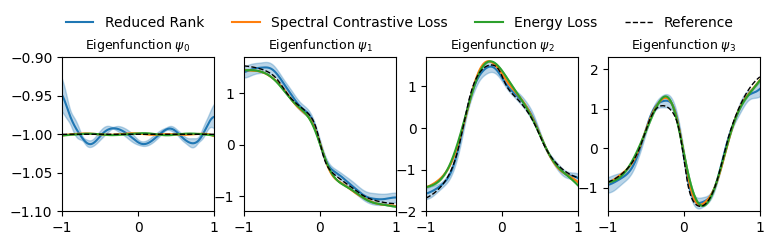

In [23]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for fun_id, ax in enumerate(axs):
    for method, functions in results.items():
        if method in ["Reduced Rank", "Spectral Contrastive Loss", "Energy Loss"]:
            # Standardize signs according to the reference
            functions = np.array(functions) # Convert list of arrays into array
            n_reps = functions.shape[0]
            for i in range(n_reps):
                for j in range(reference_eigfuns.shape[-1]):
                    functions[i, :, j] = standardize_sign(
                        functions[i, :, j], reference_eigfuns[:, j], x
                    )
            # Color mapping for different methods
            color_map = {
                "Reduced Rank": "tab:blue",
                "Spectral Contrastive Loss": "tab:orange",
                "Energy Loss": "tab:green",
            }
            color = color_map.get(method, "tab:blue")
            m = functions.mean(0)[:, fun_id].real
            st = functions.std(0)[:, fun_id].real
            ax.plot(x, m, color=color, label=method)
            ax.fill_between(x, m - st, m + st, color=color, alpha=0.3)
    reference = reference_eigfuns[:, fun_id]
    ax.plot(x, reference, color='k', lw=1, ls='--', label='Reference')
    ax.set_title(rf"Eigenfunction $\psi_{fun_id}$", fontsize=9)
    ax.set_xlim(-1, 1)
    ax.set_ylim(compute_ylims(reference))
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncols=4,
    frameon=False,
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.102),
)